In [14]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import re
import unicodedata

import nltk
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

from wordcloud import WordCloud

nltk.download("all")

def green_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return f"hsl(120, 100%, {font_size / 10 + 30}%)"

def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return f"hsl(0, 100%, {font_size / 10 + 30}%)"

def create_wordcloud(frequency_dict, image_path, color_func=None):
    mask = np.array(Image.open(image_path))
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        mask=mask, 
        contour_color='black', 
        contour_width=1,
        color_func=color_func
    ).generate_from_frequencies(frequency_dict)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.text(0, 0.5, "RU:2795409", fontsize=20, 
             va='center', ha='right', rotation=90, transform=plt.gca().transAxes)
    plt.show()

def remove_accentuation(text):
    nfkd_form = unicodedata.normalize('NFKD', text)
    return u"".join([char for char in nfkd_form if not unicodedata.combining(char)])

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text.strip()
    
    words = word_tokenize(text)
    stop_words = set(stopwords.words('portuguese'))
    words = [remove_accentuation(word) for word in words if word not in stop_words]
   
    stemmer = RSLPStemmer()
    words = [stemmer.stem(word) for word in words]

    return words


def format_list_to_string(tokens, max_lengh=None):
    if max_lengh and len(tokens)>=max_lengh:
        tokens = tokens[:max_lengh]
    return ' '.join(tokens)

In [15]:
# Open, read and clear the dataset
df = pd.read_csv('corpus_fake_true_br.csv')
df.drop_duplicates(subset=['full_text'], keep='first', inplace=True)
df['cleaned_text_tokens'] = df['full_text'].apply(clean_text)
df['cleaned_text'] = df['cleaned_text_tokens'].apply(format_list_to_string, args=(100,))

# Separate the dataset into training and testing
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['boolean_tag'] # REAL = 1, FAKE = 0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Train the model and predict the test dataset to calculate the accuracy
model = LogisticRegression(solver='lbfgs')
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)
y_pred = (y_pred_proba[:, 1] >= 0.5).astype(int)
ru_2795409_accuracy = accuracy_score(y_test, y_pred)
ru_2795409_accuracy_percentage = ru_2795409_accuracy * 100
print(f"Acurácia do modelo: {ru_2795409_accuracy_percentage:.2f}%")

Acurácia do modelo: 91.06%


Número de unigramas (REAL): 3423
Número de bigramas (REAL): 1278
Número de trigramas (REAL): 264


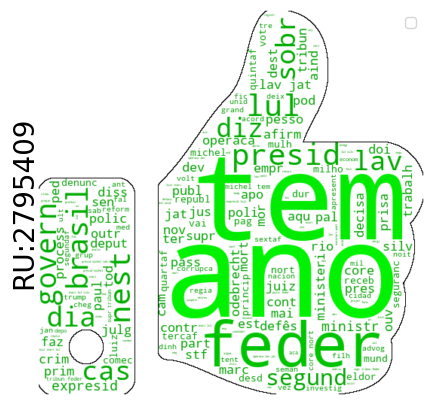

In [16]:
# REAL label: Count unigrams, bigrams and trigrams
ru_2795409_X_train_real = X_train[y_train == 1]

def count_ngrams(X, feature_names, n):
    count = 0
    for f in feature_names:
        if len(f.split()) == n and X[:, feature_names.tolist().index(f)].sum() > 0:
            count += 1
    return count

feature_names = vectorizer.get_feature_names_out()

unigrams_real = count_ngrams(ru_2795409_X_train_real, feature_names, 1) 
bigrams_real = count_ngrams(ru_2795409_X_train_real, feature_names, 2) 
trigrams_real = count_ngrams(ru_2795409_X_train_real, feature_names, 3) 

print(f"Número de unigramas (REAL): {unigrams_real}")
print(f"Número de bigramas (REAL): {bigrams_real}")
print(f"Número de trigramas (REAL): {trigrams_real}")

create_wordcloud(
    dict(zip(feature_names, ru_2795409_X_train_real.sum(axis=0).A1)),
    './thumbs_up_mask.png',
    green_color_func
)

Número de unigramas (FAKE): 3419
Número de bigramas (FAKE): 1256
Número de trigramas (FAKE): 230


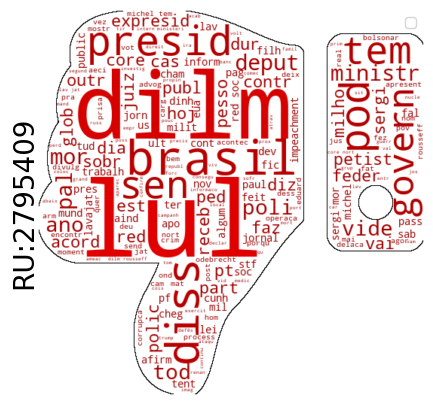

In [18]:
# FAKE label: Count unigrams, bigrams and trigrams

ru_2795409_X_train_fake = X_train[y_train == 0]

def count_ngrams(X, feature_names, n):
    count = 0
    for f in feature_names:
        if len(f.split()) == n and X[:, feature_names.tolist().index(f)].sum() > 0:
            count += 1
    return count

feature_names = vectorizer.get_feature_names_out()

unigrams_fake = count_ngrams(ru_2795409_X_train_fake, feature_names, 1) 
bigrams_fake = count_ngrams(ru_2795409_X_train_fake, feature_names, 2) 
trigrams_fake = count_ngrams(ru_2795409_X_train_fake, feature_names, 3) 

print(f"Número de unigramas (FAKE): {unigrams_fake}")
print(f"Número de bigramas (FAKE): {bigrams_fake}")
print(f"Número de trigramas (FAKE): {trigrams_fake}")

create_wordcloud(
    dict(zip(feature_names, ru_2795409_X_train_fake.sum(axis=0).A1)),
    './thumbs_down_mask.png',
    red_color_func
)